In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import math

In [2]:
year_start = 2020
year_end = 2080

init_hashrate_largest = 1e-4
init_equilibrium_price = 50000
init_reward = 6.25

num_samples = 1000

In [3]:
# Get estimated hashrate contribution of the largest possible mining centre to the network
def GetHashrateLargest(year):
    year_relative = year - year_start
    return min(hashrate_largest_stable, init_hashrate_largest + year_relative * growth_rate)

# Get price percentage offset from the mining equilibrium given largest obtainable hashrate and required drop cushion
def GetOffset(year):
    return GetHashrateLargest(year) / (hashrate_limit * (-drop_cushion + 1)) - 1

def GetMiningReward(year):
    return 6.25 * 2**(-math.floor((year - 2020) / 3.81))

# Continuous approximation for mining rewards https://medium.com/@QuantMario/the-lgs-s2f-bitcoin-price-formula-751d0aac06af
def GetMiningRewardContinuous(year):
    return 50 / 2 ** (-0.471234 + GetBlockHeight(year)/210000)

def GetSecurityLimitPrice(year):
    return round(init_equilibrium_price * (1 + GetOffset(year)) * init_reward / GetMiningRewardContinuous(year))

# S2F upper bound given by our world GDP assumption
def GetUpperBound(year):
    return 0.4 * 1.035 ** (year - 2020) * 1e8 / 17

# Not exact data, but good enough for our purposes
def GetBlockHeight(year):
    return (365 - 9) * 150 + (year - 2010) * 365 * 150

In [4]:
# Stock and flow model https://medium.com/geekculture/bitcoin-stock-to-flow-model-80beacc344b
def GetFlow(year):
    return GetMiningRewardContinuous(year) * 365 * 150

def GetStock(year):
    return 17 * 1e6 + sum([GetFlow(year) for y in range(2021, year)])

def GetSF(year):
    return GetStock(year) / GetFlow(year)

def GetStock2FlowPrice(year, capped=False):
    if capped:
        return min(0.158817 * GetSF(year) ** 3.36, GetUpperBound(year))
    else:
        return 0.158817 * GetSF(year) ** 3.36
    
# More realistic version of S2F https://medium.com/@QuantMario/the-lgs-s2f-bitcoin-price-formula-751d0aac06af
def Get_LGS_S2F_Price(year):
    a = 24.16
    b = 0.377
    c = 81 * 1e12
    block_height = GetBlockHeight(year)
    s = GetStock(year)
    return 1 / s * (c * math.exp(a * ((3.64568 * 1e6) ** b) * (-2 ** (-4.7619 * 1e-6 * b * block_height)) * s ** (-b)))

In [5]:
def format_price(price):
    if price < 1e3:
        return '$' + str(round(price))
    elif price < 1e6:
        return '$' + str(round(price/1e3)) + 'k'
    elif price < 1e9:
        return '$' + str(round(price/1e6)) + 'M'

bar_chart = False
x_years_bar = np.array([x for x in range(year_start, year_end+1, 1)])

if not bar_chart:
    x_years = np.array([x / num_samples for x in range(year_start * num_samples, year_end * num_samples)])

hashrate_limit = 0.1
hashrate_largest_stable = 1e-4
drop_cushion = 0.9
hashrate_growth_period = 10
growth_rate = (hashrate_largest_stable - init_hashrate_largest) / hashrate_growth_period

y0 = [GetSecurityLimitPrice(x) for x in x_years]

drop_cushion = 0
y0_ = [GetSecurityLimitPrice(x) for x in x_years]

hashrate_limit = 0.1
hashrate_largest_stable = 1e-3
drop_cushion = 0.9
hashrate_growth_period = 10
growth_rate = (hashrate_largest_stable - init_hashrate_largest) / hashrate_growth_period

y1 = [GetSecurityLimitPrice(x) for x in x_years]

drop_cushion = 0
y1_ = [GetSecurityLimitPrice(x) for x in x_years]

hashrate_limit = 0.1
hashrate_largest_stable = 1e-2
drop_cushion = 0.9
hashrate_growth_period = 10
growth_rate = (hashrate_largest_stable - init_hashrate_largest) / hashrate_growth_period

y2 = [GetSecurityLimitPrice(x) for x in x_years]

drop_cushion = 0
y2_ = [GetSecurityLimitPrice(x) for x in x_years]


yStock2Flow = [GetStock2FlowPrice(x, capped=True) for x in x_years_bar]
yLGS_S2F = [Get_LGS_S2F_Price(x) for x in x_years_bar]

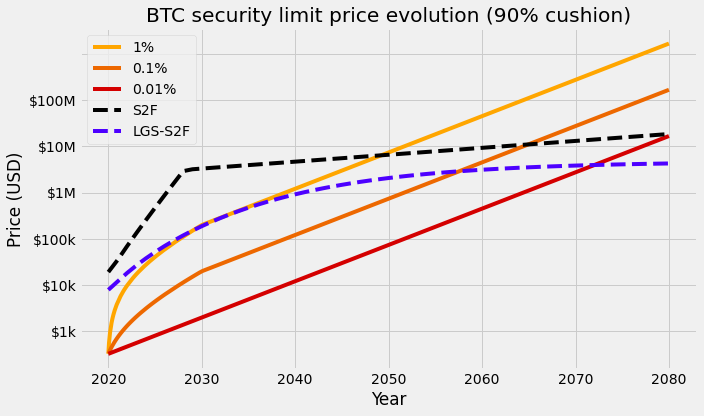

In [6]:
width = 1

plt.rcParams['figure.figsize'] = [10, 6]
plt.style.use('fivethirtyeight')

if bar_chart:
    plt.bar(x_years_bar + width, y2, width=width, label='1%')
    plt.bar(x_years_bar, y1, width=width, label='0.1%')
    plt.bar(x_years_bar - width, y0, width=width, label='0.01%')
else:
    plt.plot(x_years, y2, color='#ffa600', label='1%')
    plt.plot(x_years, y1, color='#ed6800', label='0.1%')
    plt.plot(x_years, y0, color='#d40000', label='0.01%')

plt.plot(x_years_bar, yStock2Flow, 'k--', label='S2F')
plt.plot(x_years_bar, yLGS_S2F, '--', color='#4d00ff', label='LGS-S2F')

plt.yscale('log')

plt.gca().yaxis.set_major_formatter(lambda x, pos: format_price(x))

plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('BTC security limit price evolution (90% cushion)')

plt.legend()
plt.tight_layout()

plt.savefig('BTC_security_price_evolution_cushion_90%.png')

plt.show()

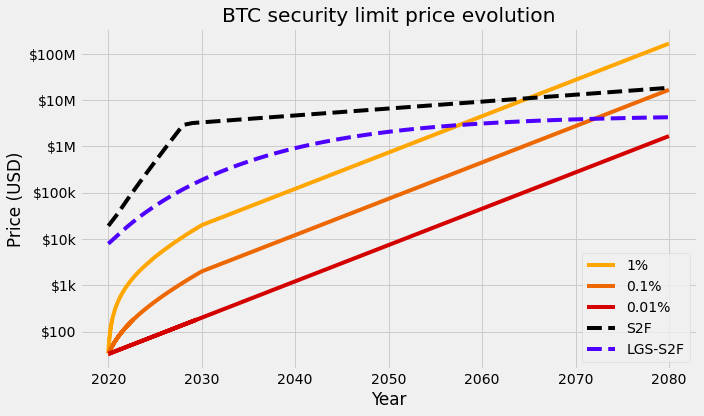

In [7]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.style.use('fivethirtyeight')

if bar_chart:
    plt.bar(x_years_bar + width, y2_, width=width, label='1%')
    plt.bar(x_years_bar, y1_, width=width, label='0.1%')
    plt.bar(x_years_bar - width, y0_, width=width, label='0.01%')
else:
    plt.plot(x_years, y2_, color='#ffa600', label='1%')
    plt.plot(x_years, y1_, color='#ed6800', label='0.1%')
    plt.plot(x_years, y0_, color='#d40000', label='0.01%')
    
plt.plot(x_years_bar, yStock2Flow, 'k--', label='S2F')
plt.plot(x_years_bar, yLGS_S2F, '--', color='#4d00ff', label='LGS-S2F')

plt.yscale('log')

plt.gca().yaxis.set_major_formatter(lambda x, pos: format_price(x))

plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('BTC security limit price evolution')

plt.legend()
plt.tight_layout()

plt.savefig('BTC_security_price_evolution.png')

plt.show()